# Book Categorization Using K-Means

Dataset: http://www.cs.cmu.edu/~dbamman/booksummaries.html

In this project, I analyze book summaries and cluster them into groups using k-Means. 

I am working with text data. Since k-Means expects data to be numeric, I prepare text by cleansing and vectorizing the data. In order to evaluate grouping, I use most popular words in each cluster.

This script can be used to solve text classification or topic tagging problems. Data preparation can be modified based on input data.

In [1]:
import numpy as np
import pandas as pd

import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

## Data Review and Preprocessing

The dataset contains plot summaries for 16,559 books extracted from Wikipedia, as well as metadata including book author, title, date, and genre.

In [2]:
data = pd.read_csv('booksummaries.txt',sep='	', header=None,
                  names=['id','id2','title','author','date', 'genre','text'])
data.head()

,id,id2,title,author,date,genre,text
0,620,/m/0hhy,Animal Farm,George Orwell,1945-08-17,"{""/m/016lj8"": ""Roman \u00e0 clef"", ""/m/06nbt"":...","Old Major, the old boar on the Manor Farm, ca..."
1,843,/m/0k36,A Clockwork Orange,Anthony Burgess,1962,"{""/m/06n90"": ""Science Fiction"", ""/m/0l67h"": ""N...","Alex, a teenager living in near-future Englan..."
2,986,/m/0ldx,The Plague,Albert Camus,1947,"{""/m/02m4t"": ""Existentialism"", ""/m/02xlf"": ""Fi...",The text of The Plague is divided into five p...
3,1756,/m/0sww,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,2080,/m/0wkt,A Fire Upon the Deep,Vernor Vinge,NaN,"{""/m/03lrw"": ""Hard science fiction"", ""/m/06n90...",The novel posits that space around the Milky ...


In [3]:
data.shape

(16559, 7)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16559 entries, 0 to 16558
Data columns (total 7 columns):
id        16559 non-null int64
id2       16559 non-null object
title     16559 non-null object
author    14177 non-null object
date      10949 non-null object
genre     12841 non-null object
text      16559 non-null object
dtypes: int64(1), object(6)
memory usage: 905.6+ KB


I have missing data in author, date and genre metadata. In this project, I'll be working with text of plot summaries only. I'll review book authors and genre to get a general overview of the books I am working with.

### Book Authors

In [5]:
data['author'].value_counts()

Agatha Christie          74
Franklin W. Dixon        68
K. A. Applegate          62
Stephen King             60
Edgar Rice Burroughs     59
John Dickson Carr        55
Ruth Rendell             55
P. G. Wodehouse          50
Harry Turtledove         49
Orson Scott Card         49
Dean Koontz              47
Rex Stout                44
Henry James              44
Philip K. Dick           43
Judy Blundell            42
Terry Pratchett          42
Alan Dean Foster         42
Piers Anthony            41
Georgette Heyer          38
Jack Vance               37
André Franquin           37
Donald Hamilton          36
Isaac Asimov             36
William Shakespeare      36
Jules Verne              36
Robert A. Heinlein       34
Mercedes Lackey          34
James Patterson          34
Bernard Cornwell         33
Gary Paulsen             33
                         ..
J. Randy Taraborrelli     1
John Willard              1
Ray Garton                1
Sol Stein                 1
Léon Frapié         

Text(0.5, 1.0, 'Top Authors')

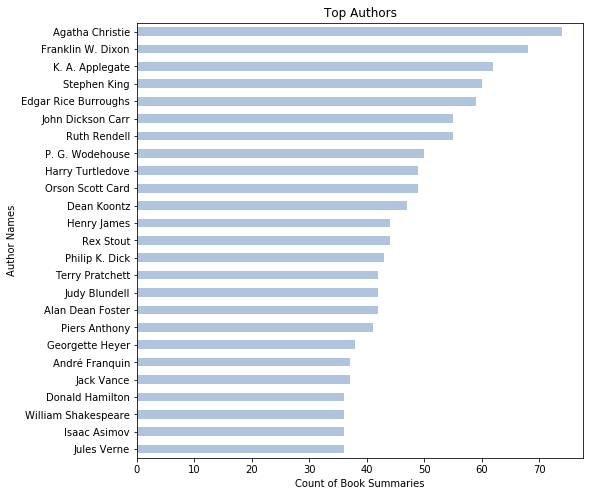

In [6]:
# plot top authors:
plt.figure(figsize=(8,8))

data_author = data.groupby('author').filter(lambda x: len(x) > 35)

data_author.author.value_counts().sort_values().plot(kind = 'barh',color='lightsteelblue')
plt.xlabel('Count of Book Summaries')
plt.ylabel('Author Names')
plt.title('Top Authors')

In [7]:
# get books with missing authors:
data_missing_authors = data.loc[data['author'].isna()]

In [8]:
# get percentage of books that miss authors:
data_missing_authors.shape[0]/data.shape[0]

0.14384926626003985

### Book Genres

In [9]:
# review books genres: 
data['genre'].value_counts()

{"/m/05hgj": "Novel"}                                                                                                                                                                                                   839
{"/m/06n90": "Science Fiction", "/m/014dfn": "Speculative fiction"}                                                                                                                                                     567
{"/m/06n90": "Science Fiction"}                                                                                                                                                                                         526
{"/m/02xlf": "Fiction"}                                                                                                                                                                                                 402
{"/m/02xlf": "Fiction", "/m/05hgj": "Novel"}                                                                            

In [10]:
# clean up genres:
data['genre'] = data['genre'].str.replace('\"\/m\/(.{4}|.{5}|.{6}|.{7})\"\:', '').str.replace('\{|\}|\"', '').str.strip()

Text(0.5, 1.0, 'Top Categories')

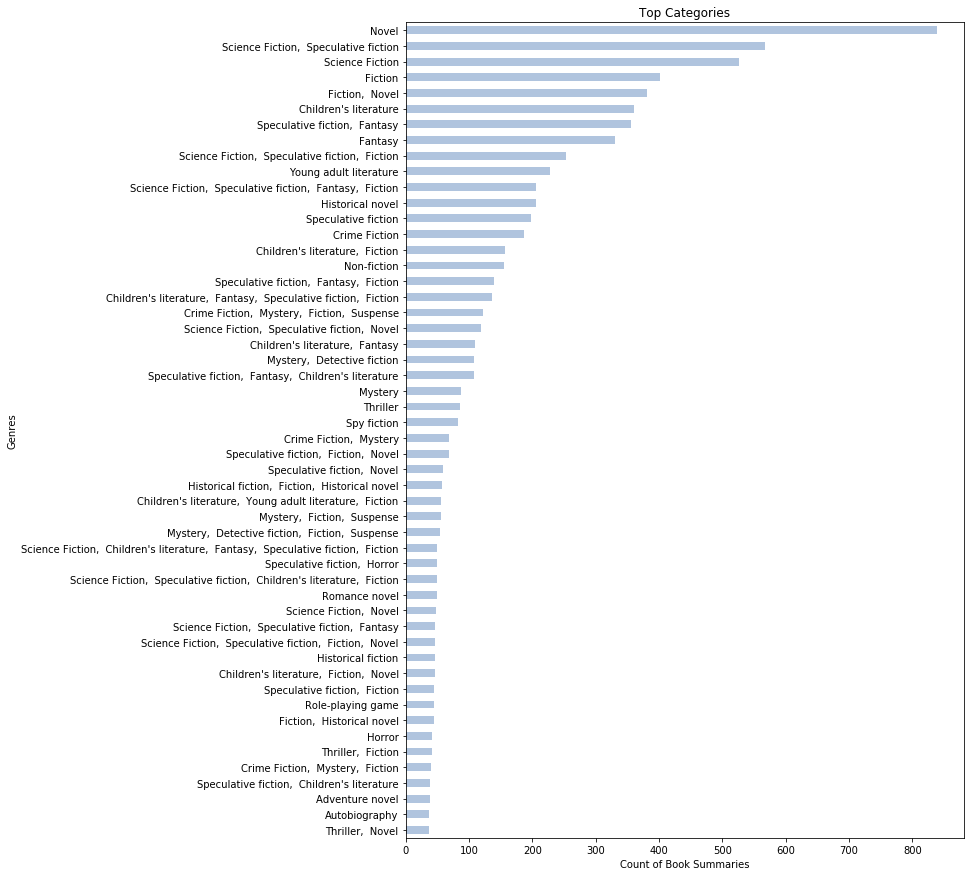

In [11]:
# plot top authors:
plt.figure(figsize=(10,15))

data_genre = data.groupby('genre').filter(lambda x: len(x) > 35)

data_genre.genre.value_counts().sort_values().plot(kind = 'barh',color='lightsteelblue')
plt.xlabel('Count of Book Summaries')
plt.ylabel('Genres')
plt.title('Top Categories')

In [12]:
# # get book counts per genre:
# print(data['genre'].value_counts())

In [13]:
# # get books with missing genre:
# data.loc[data['genre'].isna()]

In [14]:
data_missing = data.loc[data['genre'].isna()]

In [15]:
# get percentage of books with missing genres:
data_missing.shape[0]/data.shape[0]

0.22453046681562897

I have 2,154 unique values for book genres. Many books are tagged by multiple genres, and I have a lot of books that are unique in how they are tagged.

Looks like a lot of books are tagged as "Novel" and "Fiction," as well as by more nuanced tags such as "Fantasy" and "Speculative fiction." I suspect overlap in clusters.

In addition, over 22% of all books in the dataset are not tagged by any genres. The model will be a real value add as it will classify books that do not currently have any tags.

## Convert Text to TF-IDF Features

I am working with the text of plot summaries, so I have to convert text into a matrix of TF-IDF features.

In [16]:
# use Tf-Idf vectorizer to convert the text into TF-IDF features:
tfidf = TfidfVectorizer(
    # exclude terms that are too frequent:
    max_df = 0.95,
    # limit vocabulary size:
    min_df = 5,
    # limit the amount of features:
    max_features = 8000,
    # stop words:
    stop_words = 'english'
)
tfidf.fit(data.text)
text = tfidf.transform(data.text)

In [17]:
# print(text)
# text.shape

## MiniBatchKMeans

I'll use MiniBatchKMeans as my "baseline" model. I have a lot of features, and MiniBatch is faster than k-means because it works with random subsets of data in each iteration.

I'll use elbow method to review the number of optimal clusters. However, given that I work with book summaries, I'll rely on domain knowledge to determine the number of categories for book summaries in the dataset.

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters
Fit 22 clusters
Fit 24 clusters
Fit 26 clusters
Fit 28 clusters
Fit 30 clusters


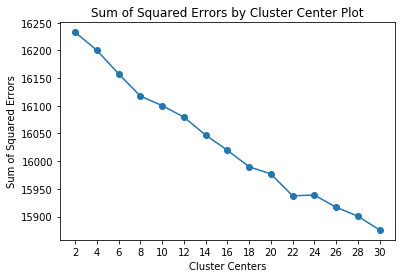

In [18]:
# elbow method to determine number of clusters:
def find_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k,
                                   init_size=1024,
                                   batch_size=2048,
                                   random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('Sum of Squared Errors')
    ax.set_title('Sum of Squared Errors by Cluster Center Plot')
    
find_clusters(text, 30)

In [19]:
# train MiniBatchKmeans with 20 clusters: 
clusters = MiniBatchKMeans(n_clusters=20,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20).fit_predict(text)

In [20]:
# function to review top keywords in each cluster:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(text, clusters, tfidf.get_feature_names(), 10)


Cluster 0
time,ship,race,world,alien,space,humans,human,planet,earth

Cluster 1
house,year,home,old,love,life,school,family,mother,father

Cluster 2
spenser,chapter,man,asterix,vlad,39,34,town,henry,village

Cluster 3
world,narrator,author,set,character,life,characters,story,book,novel

Cluster 4
leia,tardis,planet,anakin,vong,wan,obi,luke,jedi,doctor

Cluster 5
ships,planet,sea,island,aboard,enterprise,kirk,captain,crew,ship

Cluster 6
dawkins,christ,demons,book,world,faith,religion,jesus,angel,god

Cluster 7
life,death,help,finds,people,city,man,time,new,world

Cluster 8
novel,character,cycle,trojan,groups,tense,companions,gods,utopia,di

Cluster 9
magic,throne,castle,dragon,army,princess,kingdom,queen,prince,king

Cluster 10
wife,book,new,named,time,ship,father,story,stephen,jack

Cluster 11
new,time,mother,cammie,family,frodo,father,ben,anna,sam

Cluster 12
american,army,united,bond,soviet,states,german,world,british,war

Cluster 13
septimus,new,chloe,witch,father,sir,clary,jace,c

Judging by top keywords in each group of summaries, the model is doing ok. I see overlapping clusters, as well as need for additional text preparation.

I'll also use a silhouette score to see how the model is doing.

In [21]:
# calculate silhouette score:
clusters = MiniBatchKMeans(n_clusters=20,
                           init_size=1024,
                           batch_size=2048,
                           random_state=20)
clusters.fit(text)
clusters.predict(text)
clusters.labels_

silhouette_score(text, labels=clusters.predict(text))

0.003432465507639966

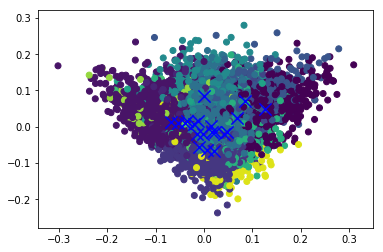

In [22]:
# plot clusters:
# reduce the features to 2D
pca = PCA(n_components=2, random_state=42)
reduced_features = pca.fit_transform(text.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(clusters.cluster_centers_)

plt.scatter(reduced_features[:,0],
            reduced_features[:,1],
            c=clusters.predict(text))
plt.scatter(reduced_cluster_centers[:, 0],
            reduced_cluster_centers[:,1],
            marker='x',
            s=150,
            c='b')

The score and the image show that my clusters are overlapping, which was expected. I'll use top keywords to evaluate the models.

## Data Cleaning

### Remove Digits

In [23]:
# remove digits:
data['text'] = data['text'].str.replace('\d', '')

### Remove Stop Words

I will use the standard English stop words library, plus additional words I have identified when reviewing the initial results.

In [24]:
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(
    ['character', 'mr', 'mrs', 'miss','characters',
    'narrator', 'author', 'tells', 'narrates',
    'book', 'chapter', 'story'])

### Convert Text to TF-IDF Features

In [25]:
# use Tf-Idf vectorizer to convert the text into TF-IDF features:
tfidf = TfidfVectorizer(
    # exclude terms that are too frequent:
    max_df = 0.95,
    # limit vocabulary size:
    min_df = 5,
    # limit the amount of features:
    max_features = 8000,
    # stop words:
    stop_words = my_stop_words
)
tfidf.fit(data.text)
text = tfidf.transform(data.text)

## K-Means Clustering

Data is high-dimensional, which will slow down k-means in measuring distances between each data point and the mean. In order to reduce dimensionality, I'll use truncated singular value decomposition (SVD) which works well with sparse matrices. 

## k=20
I'll first train k-Means with 20 clusters.

In [26]:
# reduce dimensionality using truncated SVD: 
svd = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
svd_text = svd.fit_transform(text)

# train k-means on data:
clusters20 = KMeans(n_clusters=20,
                  init='k-means++',
                 random_state=42).fit_predict(svd_text)

In [27]:
# get top keywords:
get_top_keywords(text, clusters20, tfidf.get_feature_names(), 10)


Cluster 0
history,century,work,human,society,time,new,people,life,world

Cluster 1
husband,father,sir,life,woman,wife,man,young,john,love

Cluster 2
castle,son,conan,army,princess,kingdom,arthur,queen,prince,king

Cluster 3
way,time,power,evil,help,people,dragon,magic,world,city

Cluster 4
space,planet,sea,enterprise,aboard,kirk,island,captain,crew,ship

Cluster 5
fails,failing,failed,fail,faerie,fairy,zoo,plot,description,outline

Cluster 6
home,family,house,finds,young,man,time,old,life,new

Cluster 7
han,leia,republic,skywalker,anakin,vong,luke,wan,obi,jedi

Cluster 8
time,ship,race,world,alien,space,humans,human,planet,earth

Cluster 9
president,american,army,german,soviet,british,united,states,world,war

Cluster 10
new,teacher,friends,old,girl,father,year,mother,boy,school

Cluster 11
death,investigation,wolfe,man,alex,detective,killer,case,police,murder

Cluster 12
yeerks,tobias,marco,rachel,ax,visser,cassie,animorphs,jake,david

Cluster 13
john,edward,family,england,mary,father

Clustering worked ok, many clusters are overlapping, which is expected with the data in the dataset. I see a few general topics, so I'll try 10 clusters.

## k=10

In [28]:
# reduce dimensionality using truncated SVD: 
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=42)
svd_text = svd.fit_transform(text)

# train k-means on data:
clusters10 = KMeans(n_clusters=10,
                  init='k-means++',
                 random_state=42).fit_predict(svd_text)
        
get_top_keywords(text, clusters10, tfidf.get_feature_names(), 10)


Cluster 0
kingdom,battle,lord,army,city,queen,dragon,magic,prince,king

Cluster 1
young,children,old,home,love,school,life,mother,father,family

Cluster 2
new,fictional,outline,follows,young,set,plot,life,concerns,novel

Cluster 3
work,novel,god,society,new,time,human,life,people,world

Cluster 4
president,american,army,soviet,german,british,world,united,states,war

Cluster 5
pirates,boat,aubrey,aboard,sea,island,captain,crew,ship,jack

Cluster 6
help,father,young,finds,man,school,time,life,old,new

Cluster 7
sir,death,john,woman,house,wife,case,man,police,murder

Cluster 8
race,jedi,crew,human,alien,humans,space,ship,earth,planet

Cluster 9
martha,fitz,companions,planet,earth,alien,time,ace,tardis,doctor


Let's try the model with even fewer clusters.

## k = 6

In [29]:
# reduce dimensionality using truncated SVD: 
svd = TruncatedSVD(n_components=6, n_iter=7, random_state=42)
svd_text = svd.fit_transform(text)

# train k-means on data:
clusters6 = KMeans(n_clusters=6,
                  init='k-means++',
                 random_state=42).fit_predict(svd_text)
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
get_top_keywords(text, clusters6, tfidf.get_feature_names(), 10)


Cluster 0
children,house,home,old,love,life,school,mother,father,family

Cluster 1
president,american,army,german,soviet,world,united,states,british,war

Cluster 2
kingdom,battle,army,lord,city,magic,dragon,queen,prince,king

Cluster 3
young,plot,time,people,set,new,concerns,world,life,novel

Cluster 4
life,young,police,finds,old,house,murder,time,new,man

Cluster 5
time,world,alien,crew,humans,human,space,ship,planet,earth


The final version of the model grouped book summaries into distinct groups:

- Cluster 0 - children/young adult
- Cluster 1 - history/world
- Cluster 2 - fantasy
- Cluster 3 - novel
- Cluster 4 - detective/thriller
- Cluster 5 - scence fiction

## Summary

In this project, I worked with text data to group book summaries. I prepared data by vectorizing text, as well as cleaning it up from digits and unhelpful words. I grouped book summaries into six categories and evaluated groups by reviewing top keywords in each category.

I treated this project as a real life problem where I'd be tasked with classifying text without any labels. I wanted to come up with a logical solution to a problem where there is no set way to evaluate model's performance. I could use silhouette score, but I relied on domain knowledge and top keywords to evaluate groups. 

I used some NLP techniques such as TD-IDF. Further work could enhance text preprocessing by using more advanced NLP techniques such as tokenization, stemming, and lemmatization.

In addition, the project could potentially be turned into a classification problem using KNN. To create labels, one would have to analyze 2,154 unique genre tags to create fewer general categories, label the data and use the labels in training and validating the model. One could then use the model to categorize 22% of book summaries that don't have tags. Model selection would depend on business needs.